In [6]:
import pathlib
import warnings
from typing import List, Dict

import gym
import gym_corridor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lcs import Perception
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from myst_nb import glue

from src.basic_rl import run_q_learning_alternating, run_r_learning_alternating, qlearning, rlearning
from src.decorators import repeat, get_from_cache_or_run
from src.diminishing_reward import common_metrics
from src.observation_wrappers import CorridorObservationWrapper
from src.payoff_landscape import get_all_state_action, plot_payoff_landscape
from src.runner import run_experiments_alternating
from src.utils import build_cache_dir_path, build_plots_dir_path
from src.visualization import PLOT_DPI, diminishing_reward_colors

plt.ioff()  # turn off interactive plotting
plt.style.use('../../../src/phd.mplstyle')

root_dir = pathlib.Path().cwd().parent.parent.parent
cwd_dir = pathlib.Path().cwd()

plot_dir = build_plots_dir_path(root_dir) / cwd_dir.name
cache_dir = build_cache_dir_path(root_dir) / cwd_dir.name


def average_experiment_runs(run_df: pd.DataFrame) -> pd.DataFrame:
    return run_df.groupby(['agent', 'trial', 'phase']).mean().reset_index(level='phase')

def plot_pop_and_rho(df, trials, plot_filename=None):
    colors = diminishing_reward_colors()

    expl_df = df[df['phase'] == 'exploit']

    fig, axs = plt.subplots(2, 1, figsize=(18, 16), sharex=True)
    xmax = trials / 2

    # Steps in trial plot
    for alg in ['ACS2', 'AACS2_v1', 'AACS2_v2', 'Q-Learning', 'R-Learning']:
        alg_df = expl_df.loc[alg]
        idx = pd.Index(name='exploit trial', data=np.arange(1, len(alg_df) + 1))
        alg_df.set_index(idx, inplace=True)

        alg_df['steps_in_trial'].rolling(window=250).mean().plot(ax=axs[0], label=alg, linewidth=2, color=colors[alg])

    axs[0].set_xlim(0, xmax)
    axs[0].set_xlabel("Exploit trial")
    axs[0].xaxis.set_major_locator(MultipleLocator(500))
    axs[0].xaxis.set_minor_locator(MultipleLocator(100))
    axs[0].xaxis.set_major_formatter(FormatStrFormatter('%1.0f'))
    axs[0].xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[0].xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')

    axs[0].set_ylabel("Number of steps")
    axs[0].set_yscale('log')
    axs[0].set_title('Steps in trial')
    axs[0].legend(loc='upper right', frameon=False)

    # Rho plot
    for alg in ['AACS2_v1', 'AACS2_v2', 'R-Learning']:
        alg_df = expl_df.loc[alg]
        idx = pd.Index(name='exploit trial', data=np.arange(1, len(alg_df) + 1))
        alg_df.set_index(idx, inplace=True)

        alg_df['rho'].rolling(window=1).mean().plot(ax=axs[1], label=alg, linewidth=2, color=colors[alg])

    axs[1].set_xlim(0, xmax)
    axs[1].set_xlabel("Exploit trial")
    axs[1].xaxis.set_major_locator(MultipleLocator(500))
    axs[1].xaxis.set_minor_locator(MultipleLocator(100))
    axs[1].xaxis.set_major_formatter(FormatStrFormatter('%1.0f'))
    axs[1].xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[1].xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')

    axs[1].set_ylabel(r"$\mathregular{\rho}$")
    axs[1].yaxis.set_major_locator(MultipleLocator(25))
    axs[1].yaxis.set_minor_locator(MultipleLocator(5))
    axs[1].yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[1].yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    axs[1].set_ylim(0, 100)

    axs[1].set_title(r'Estimated average $\mathregular{\rho}$')

    if plot_filename:
        fig.savefig(plot_filename, dpi=PLOT_DPI, bbox_inches='tight')

    return fig

# Experiment 1 - Corridor environment

In [7]:
# Params
learning_rate = 0.8
discount_factor = 0.95
epsilon = 0.2
zeta = 0.0001

def corridor_env_provider():
    return CorridorObservationWrapper(gym.make(f'corridor-20-v0'))

# Set ACS2/AACS2 configuration parameter dictionary
basic_cfg = {
    'perception_bits': 1,
    'possible_actions': 2,
    'do_ga': False,
    'beta': learning_rate,
    'epsilon': epsilon,
    'gamma': discount_factor,
    'zeta': zeta,
    'user_metrics_collector_fcn': common_metrics,
    'biased_exploration_prob': 0,
    'metrics_trial_freq': 1
}

NUM_EXPERIMENTS = 10
trials = 10_000


@get_from_cache_or_run(cache_path=f'{cache_dir}/corridor/acs2.dill')
@repeat(num_times=NUM_EXPERIMENTS)
def run_acs2_in_corridor():
    return run_experiments_alternating(corridor_env_provider, trials, basic_cfg)


@get_from_cache_or_run(cache_path=f'{cache_dir}/corridor/qlearning.dill')
def run_qlearning_in_corridor():
    corridor_env = corridor_env_provider()
    init_Q = np.zeros((corridor_env.observation_space.n, corridor_env.action_space.n))
    return run_q_learning_alternating(NUM_EXPERIMENTS, trials, corridor_env, epsilon, learning_rate, discount_factor,
                                      init_Q, perception_to_state_mapper=lambda p: int(p[0]))


@get_from_cache_or_run(cache_path=f'{cache_dir}/corridor/rlearning.dill')
def run_rlearning_in_corridor():
    corridor_env = corridor_env_provider()
    init_R = np.zeros((corridor_env.observation_space.n, corridor_env.action_space.n))
    return run_r_learning_alternating(NUM_EXPERIMENTS, trials, corridor_env, epsilon, learning_rate, zeta, init_R,
                                      perception_to_state_mapper=lambda p: int(p[0]))


# run computations
acs2_runs_details = run_acs2_in_corridor()
q_learning_metrics = run_qlearning_in_corridor()
r_learning_metrics = run_rlearning_in_corridor()

# average runs and create aggregated metrics data frame
acs2_metrics = [m_df for _, _, _, m_df in acs2_runs_details]

agg_df = pd.concat([
    average_experiment_runs(pd.concat(acs2_metrics)),
    average_experiment_runs(pd.DataFrame(q_learning_metrics)),
    average_experiment_runs(pd.DataFrame(r_learning_metrics))]
)

In [8]:
# payoff landscape
corridor_env = corridor_env_provider()
state_action = get_all_state_action(corridor_env.unwrapped._state_action())


def calculate_state_action_payoffs(state_actions: List, pop_acs2, pop_aacs2v1, pop_aacs2v2, Q, R) -> Dict:
    payoffs = {}

    for sa in state_actions:
        p = Perception((sa.state,))

        # ACS2
        acs2_match_set = pop_acs2.form_match_set(p)
        acs2_action_set = acs2_match_set.form_action_set(sa.action)

        # AACS2_v1
        aacs2v1_match_set = pop_aacs2v1.form_match_set(p)
        aacs2v1_action_set = aacs2v1_match_set.form_action_set(sa.action)

        # AACS2_v2
        aacs2v2_match_set = pop_aacs2v2.form_match_set(p)
        aacs2v2_action_set = aacs2v2_match_set.form_action_set(sa.action)

        # Check if all states are covered
        for alg, action_set in zip(['ACS2', 'AACS2_v1', 'AACS2_v2'],
                                   [acs2_action_set, aacs2v1_action_set,
                                    aacs2v2_action_set]):
            if len(action_set) == 0:
                warnings.warn(f"No {alg} classifiers for perception: {p}, action: {sa.action}")

        payoffs[sa] = {
            'ACS2': np.mean(list(map(lambda cl: cl.r, acs2_action_set))),
            'AACS2_v1': np.mean(list(map(lambda cl: cl.r, aacs2v1_action_set))),
            'AACS2_v2': np.mean(list(map(lambda cl: cl.r, aacs2v2_action_set))),
            'Q-Learning': Q[int(sa.state), sa.action],
            'R-Learning': R[int(sa.state), sa.action]
        }

    return payoffs


# Take first of each algorithm population pass for presenting payoff landscape
pop_acs2, pop_aacs2v1, pop_aacs2v2, _ = acs2_runs_details[0]


@get_from_cache_or_run(cache_path=f'{cache_dir}/corridor/qlearning-single.dill')
def run_single_qlearning():
    Q_init = np.zeros((corridor_env.observation_space.n, corridor_env.action_space.n))
    Q, _ = qlearning(corridor_env, trials, Q_init, epsilon, learning_rate, discount_factor, perception_to_state_mapper=lambda p: int(p[0]))
    return Q


@get_from_cache_or_run(cache_path=f'{cache_dir}/corridor/rlearning-single.dill')
def run_single_rlearning():
    R_init = np.zeros((corridor_env.observation_space.n, corridor_env.action_space.n))
    R, rho, _ = rlearning(corridor_env, trials, R_init, epsilon, learning_rate, zeta, perception_to_state_mapper=lambda p: int(p[0]))
    return R, rho


Q = run_single_qlearning()
R, rho = run_single_rlearning()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    payoffs = calculate_state_action_payoffs(state_action, pop_acs2, pop_aacs2v1, pop_aacs2v2, Q, R)

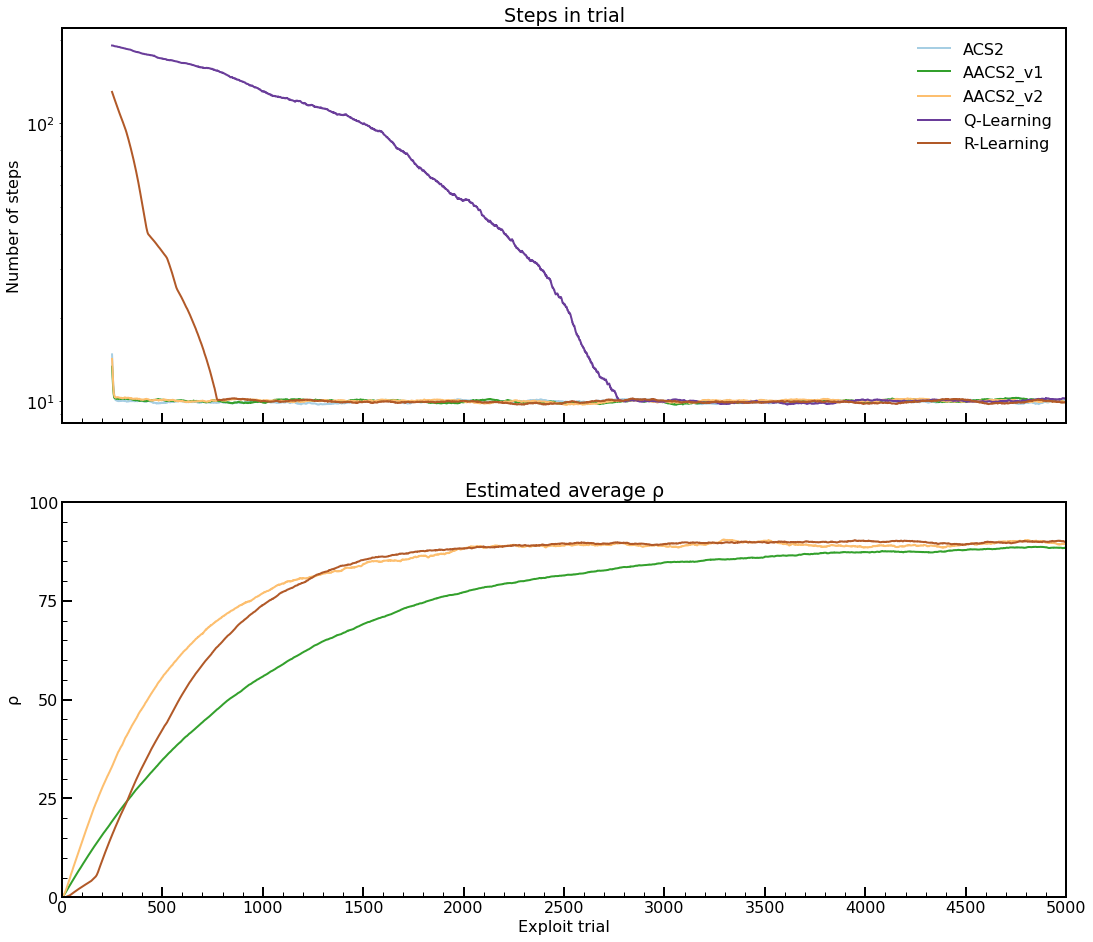

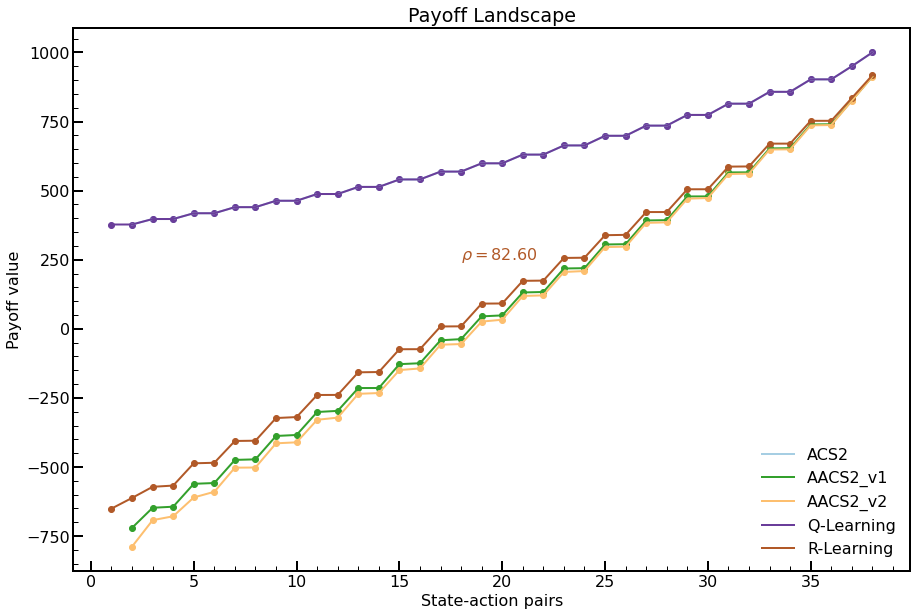

In [9]:
corridor_performance_fig = plot_pop_and_rho(agg_df, trials=trials, plot_filename=f'{plot_dir}/fsw-performance.png')
corridor_payoff_fig = plot_payoff_landscape(payoffs, rho=rho, rho_text_location={'x': 18, 'y': 250}, plot_filename=f'{plot_dir}/corridor-payoff-landscape.png')

glue('51-corridor-fig', corridor_performance_fig, display=False)
glue('51-corridor-payoff-fig',corridor_payoff_fig , display=False)

````{tabbed} Performance
```{glue:figure} 51-corridor-fig
:name: "51-corridor-fig"
Performance in Corridor-20 environment
```
````

````{tabbed} Payoff Landscape
```{glue:figure} 51-corridor-payoff-fig
:name: "51-corridor-payoff-fig"
Corridor-20 Payoff Landscape
```
````

## Statistical verification

```{admonition} Hypothesis testing
:class: tip
3 subplots (AACSv1, AACSv2, R-learning) for the distribution of of estimated average for 3 corridor sizes.
```

## Observations
...